Input Genre: [''] Range of rating (0.0, 10.0) Range of ep no: (0, 100000000)
SELECT title, rating, genre, num_episodes FROM tv_shows WHERE rating BETWEEN 0.0 AND 10.0 AND  num_episodes BETWEEN 0 AND 100000000 ORDER BY rating DESC
('Breaking Bad', 9.5, 'Crime, Drama, Thriller', 62)
('Planet Earth II', 9.5, 'Documentary', 6)
('Planet Earth', 9.4, 'Documentary, Family', 11)
('Band of Brothers', 9.4, 'Drama, History, War', 10)
('Bluey', 9.4, 'Animation, Family', 173)
('Chernobyl', 9.3, 'Drama, History, Thriller', 5)
('The Wire', 9.3, 'Crime, Drama, Thriller', 60)
('Avatar: The Last Airbender', 9.3, 'Animation, Action, Adventure', 62)
('Blue Planet II', 9.3, 'Documentary', 7)
('Cosmos: A Spacetime Odyssey', 9.3, 'Documentary', 13)
('Cosmos', 9.3, 'Documentary', 13)
('Our Planet', 9.3, 'Documentary', 12)
('Scam 1992: The Harshad Mehta Story', 9.3, 'Biography, Crime, Drama', 10)
('The Sopranos', 9.2, 'Crime, Drama', 86)
('Game of Thrones', 9.2, 'Action, Adventure, Drama', 74)
('The World at W

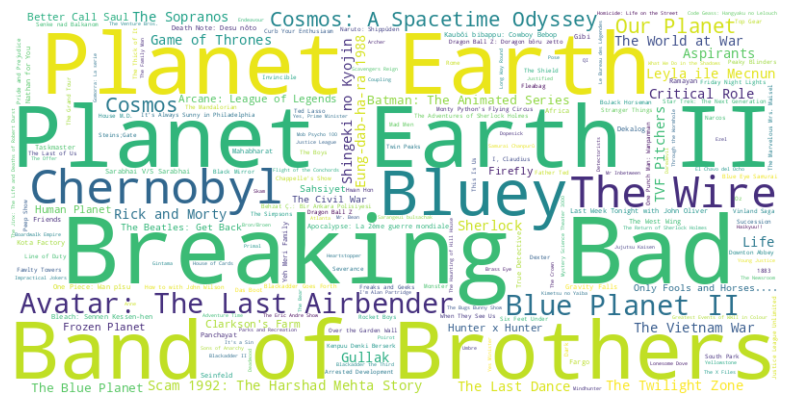

In [1]:
import requests
from bs4 import BeautifulSoup
import mysql.connector
from requests_html import HTMLSession
import pymysql
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
import numpy as np
from cv2 import imread


def scrape_imdb():
    url = 'https://www.imdb.com/chart/toptv/?ref_=nv_tvv_250/headers'
    s = HTMLSession()
    req = s.get(url)
    page = BeautifulSoup(req.text,'html.parser')

    # print(page)

    bodycontent = page.find(id='__NEXT_DATA__')

    # print(len(bodycontent))

    pagebody = bodycontent.get_text()

    # pagebody = [body.text for body in bodycontent]
    # pagebody = "".join(pagebody)
    serial_no = re.finditer(r'{"currentRank":(\d+)', pagebody)
    episodes_list = re.finditer(r'{"episodes":{"total":(\d+)', pagebody)
    ratings_list = re.finditer(r'{"aggregateRating":([0-9.]+)', pagebody)# float of group(1) for this
    genres_list = re.finditer(r'{"genres":\[(.*?)\],"__typename":"TitleGenres"}', pagebody)
    titles_list = re.finditer(r'originalTitleText":{"text":\"(.*?)\","__typename":"TitleText"}', pagebody)

    movie_genres_list =[]

    for genre in genres_list:
        genres_for_movie = re.finditer(r'{"genre":{"text":\"(.*?)\","__typename":"GenreItem"}', genre.group(1))
        movie_genres_list.append([ gen.group(1) for gen in genres_for_movie])
    
    return {'id':serial_no,'titles': titles_list, 'ratings': ratings_list, 'genres': movie_genres_list, 'num_episodes': episodes_list}


def save_to_database(data):
    db = mysql.connector.connect(host='localhost', user='prabhav', password='Prabhav123!', database='top_250_shows')
    cursor = db.cursor()

    cursor.execute("CREATE TABLE IF NOT EXISTS tv_shows(id INT, title VARCHAR(255), rating FLOAT, genre VARCHAR(255), num_episodes INT );")

    cursor.execute("DELETE FROM tv_shows")

    for id,title, rating, genre, num_episode in zip(data['id'],data['titles'], data['ratings'], data['genres'], data['num_episodes']):
        genre_str = ', '.join(genre)
        id = id.group(1)
        title = title.group(1)
        rating = rating.group(1)
        num_episode = num_episode.group(1)
        # print(title.group(1)+' '+rating.group(1)+' '+genre_str+' '+num_episode.group(1))
        insert_query = "INSERT INTO tv_shows (id,title, rating, genre, num_episodes) VALUES (%s, %s, %s, %s, %s)"
        cursor.execute(insert_query, (id,title, rating, genre_str, num_episode))

    db.commit()
    db.close()


def filter_tv_shows( genre, imdb_rating_range, num_episodes_range):
    db = mysql.connector.connect(host='localhost', user='prabhav', password='Prabhav123!', database='top_250_shows')

    cursor = db.cursor()

    query = "SELECT title, rating, genre, num_episodes FROM tv_shows WHERE"
    conditions = []

    if genre:
        for gen in genre:
            if gen:
                conditions.append(f" genre LIKE '%{gen}%'")
    if imdb_rating_range:
        min_rating, max_rating = imdb_rating_range
        conditions.append(f" rating BETWEEN {min_rating} AND {max_rating}")
    if num_episodes_range:
        min_episodes, max_episodes = num_episodes_range
        conditions.append(f" num_episodes BETWEEN {min_episodes} AND {max_episodes}")

    if conditions:
        query += " AND ".join(conditions)

    query += " ORDER BY rating DESC"
    print(query)
    cursor.execute(query)
    filtered_shows = cursor.fetchall()

    show_names = []
    for show in filtered_shows:
        print(show)
        show_names.append(show[0])
    
    db.close()

    return show_names


def prompt_user():
    genre = input("Enter genre (leave blank for any): ")
    genre = genre.split(" ")
    min_rating = float(input("Enter minimum IMDb rating (leave blank for any): ").strip() or 0)
    max_rating = float(input("Enter maximum IMDb rating (leave blank for any): ").strip() or 10.0)
    min_episodes = int(input("Enter minimum number of episodes (leave blank for any): ").strip() or 0)
    max_episodes = int(input("Enter maximum number of episodes (leave blank for any): ").strip() or 100000000)

    return genre, (min_rating, max_rating), (min_episodes, max_episodes)


def scrape_n_insert():
    scraped_data = scrape_imdb()
    save_to_database(scraped_data)
    return


def get_filter():
    genre, imdb_rating_range, num_episodes_range = prompt_user()
    print("Input","Genre:",genre,"Range of rating", imdb_rating_range,"Range of ep no:", num_episodes_range)
    create_word_cloud(filter_tv_shows( genre, imdb_rating_range, num_episodes_range))
    return


def plot_genre_bar_graph():
    db = mysql.connector.connect(host='localhost', user='prabhav', password='Prabhav123!', database='top_250_shows')
    cursor = db.cursor()

    genre_query = "SELECT genre FROM tv_shows"
    cursor.execute(genre_query)
    genre_data = cursor.fetchall()

    db.close()

    genres = [genre[0].split(', ') for genre in genre_data]
    flattened_genres = [genre for sublist in genres for genre in sublist]

    # print(len(flattened_genres))
    genre_counts = {genre: flattened_genres.count(genre) for genre in set(flattened_genres)}
    # total_shows = 0
    # for genq in genre_counts.values():
    #     total_shows += genq

    # print(total_shows)
    # print(type(genre_counts))
    plt.figure(figsize=(10, 6))
    plt.bar(genre_counts.keys(), genre_counts.values())
    plt.xlabel('Genre')
    plt.ylabel('Number of TV Shows')
    plt.title('Count of TV Shows by Genre')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    

def plot_episode_line_graph():
    db = mysql.connector.connect(host='localhost', user='prabhav', password='Prabhav123!', database='top_250_shows')
    cursor = db.cursor()

    episode_query = "SELECT num_episodes FROM tv_shows"
    cursor.execute(episode_query)
    episode_data = cursor.fetchall()

    db.close()


    episode_counts = {}
    for episode in episode_data:
        num_episodes = episode[0]
        episode_counts[num_episodes] = episode_counts.get(num_episodes, 0) + 1

    print(episode_counts)
    sorted_counts = {}
    for i in sorted(episode_counts):
        if i<30:
            sorted_counts[i]=episode_counts[i]
    # sorted_counts = {i:episode_counts[i] for i in sorted(episode_counts)}
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_counts.keys(), sorted_counts.values(), marker='o', linestyle='-')
    plt.xlabel('Number of Episodes')
    plt.ylabel('Frequency Count')
    plt.title('Frequency Count of TV Shows by Number of Episodes')
    plt.xticks(list(sorted_counts.keys()))
    plt.grid(True)
    plt.show()


def plot():
    plot_genre_bar_graph()

    plot_episode_line_graph()


def create_word_cloud(tv_show_names):

    wordsize = [1000-2*i for i in range(len(tv_show_names))]

    words = { tv_show_names[i]:wordsize[i] for i in range(len(tv_show_names)) }

    # cloud_mask = np.array(imread('cloud.jpeg'))
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate_from_frequencies(words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

    # print(tv_show_names[0])


# scrape_n_insert()
    
get_filter()
    
# plot()